In [ ]:
!nvidia-smi

Thu Oct 17 07:45:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abhi8923shriv/sentiment-analysis-dataset")

print("Path to dataset files:", path)

100%|██████████| 54.4M/54.4M [00:03<00:00, 15.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/abhi8923shriv/sentiment-analysis-dataset/versions/9


In [ ]:
import shutil

# Define source and destination paths
source_path = '/root/.cache/kagglehub/datasets/abhi8923shriv/sentiment-analysis-dataset/versions/9'
destination_path = '/content/gdrive/My Drive/sentiment-analysis-dataset'

# Copy the dataset to Google Drive
shutil.copytree(source_path, destination_path)

print("Dataset successfully transferred to Google Drive.")

Dataset successfully transferred to Google Drive.


In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout, Bidirectional, Concatenate, Input
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report
from tensorflow.keras.models import Model
from sklearn.preprocessing import OneHotEncoder

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [ ]:
#Read Data

train = pd.read_csv('/content/gdrive/MyDrive/sentiment-analysis-dataset/train.csv', encoding='ISO-8859-1')

test = pd.read_csv('/content/gdrive/MyDrive/sentiment-analysis-dataset/test.csv', encoding='ISO-8859-1')

df = pd.DataFrame(train)
df_test = pd.DataFrame(test)

In [ ]:
print(df.head())

       textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment Time of Tweet Age of User  \
0  I`d have responded, if I were going   neutral       morning        0-20   
1                             Sooo SAD  negative          noon       21-30   
2                          bullying me  negative         night       31-45   
3                       leave me alone  negative       morning       46-60   
4                        Sons of ****,  negative          noon       60-70   

       Country  Population -2020  Land Area (Km²)  Density (P/Km²)  
0  Afghanistan          38928346         652860.0    

In [ ]:
# remove unwanter columns

df.drop(['Density (P/Km²)', 'Land Area (Km²)', 'Population -2020', 'Age of User', 'Time of Tweet', 'selected_text', 'Country', 'textID'], axis=1, inplace=True)

df_test.drop(['Density (P/Km²)', 'Land Area (Km²)', 'Population -2020', 'Age of User', 'Time of Tweet', 'Country'], axis=1, inplace=True)

In [ ]:
print(df.head())

                                                text sentiment
0                I`d have responded, if I were going   neutral
1      Sooo SAD I will miss you here in San Diego!!!  negative
2                          my boss is bullying me...  negative
3                     what interview! leave me alone  negative
4   Sons of ****, why couldn`t they put them on t...  negative


In [ ]:
# cleaning data

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

df.dropna(inplace=True)
df_test.dropna(inplace=True)
def preprocess_text(text):
    if not isinstance(text, str):
        return ''
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    tokens = [word for word in text.split() if word not in stop_words]
    return ' '.join(tokens)

# Ensure the 'text' column is of string type

df['text'] = df['text'].astype(str)
df_test['text'] = df_test['text'].astype(str)

df['text'] = df['text'].apply(preprocess_text)
df_test['text'] = df_test['text'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
print(df.head())

                                       text sentiment
0                        id responded going   neutral
1                   sooo sad miss san diego  negative
2                             boss bullying  negative
3                     interview leave alone  negative
4  sons couldnt put releases already bought  negative


In [ ]:
# tokenization

tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(df['text'].values)
X = tokenizer.texts_to_sequences(df['text'])
X = pad_sequences(X, maxlen=100)
y = pd.get_dummies(df['sentiment']).values

tokenizer.fit_on_texts(df_test['text'])
X_test_data = tokenizer.texts_to_sequences(df_test['text'])
X_test_data = pad_sequences(X_test_data, maxlen=100)
y_test_data = pd.get_dummies(df_test['sentiment']).values

In [ ]:
# mLSTM Model
# Sample data shapes

num_samples = 1000          # Number of samples
max_text_length = 100        # Max length for text sequences
num_features_text = 128     # Features for text data (e.g., embedding size)

text_input = Input(shape=(max_text_length,), name='text_input')
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128)(text_input)
text_lstm = Bidirectional(LSTM(64, return_sequences=True))(embedding_layer)
text_lstm = Dropout(0.3)(text_lstm)
text_lstm = Bidirectional(LSTM(32))(text_lstm)
text_lstm = Dense(64, activation='relu')(text_lstm)
text_lstm = Dropout(0.5)(text_lstm)

output = Dense(3, activation='softmax')(text_lstm)

# Define the model
model = Model(inputs=text_input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# train model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=0.00001)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, lr_reduction])

Epoch 1/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 28s 31ms/step - accuracy: 0.5094 - loss: 0.9759 - val_accuracy: 0.7001 - val_loss: 0.7275 - learning_rate: 0.0010
Epoch 2/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.7288 - loss: 0.6883 - val_accuracy: 0.7014 - val_loss: 0.7219 - learning_rate: 0.0010
Epoch 3/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - accuracy: 0.7548 - loss: 0.6376 - val_accuracy: 0.7008 - val_loss: 0.7297 - learning_rate: 0.0010
Epoch 4/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.7748 - loss: 0.5927 - val_accuracy: 0.6927 - val_loss: 0.7476 - learning_rate: 0.0010
Epoch 5/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.7892 - loss: 0.5537 - val_accuracy: 0.6932 - val_loss: 0.7767 - learning_rate: 0.0010
Epoch 6/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - accuracy: 0.8185 - loss: 0.4881 - val_accuracy: 0.6822 - val_loss: 0.8813 - learning_rate: 5.0000e-04
Epoch 7/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.8347

In [ ]:
# evaluate model
# Evaluate the model on validation data

val_loss, val_accuracy = model.evaluate(X_test, y_test)

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6999 - loss: 0.7198
Validation Loss: 0.7219
Validation Accuracy: 70.14%


In [ ]:
# Make predictions on validation data
y_pred = model.predict(X_test_data)

# If it's a classification task, you might want to convert softmax probabilities to class labels:
y_pred_class = np.argmax(y_pred, axis=1)
y_true_class = np.argmax(y_test_data, axis=1)

# Compare predictions with actual labels

print(f"Predictions: {y_pred_class[:10]}")
print(f"True Labels: {y_true_class[:10]}")

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Predictions: [2 2 1 2 1 2 1 2 2 0]
True Labels: [1 2 0 2 2 2 0 0 1 1]


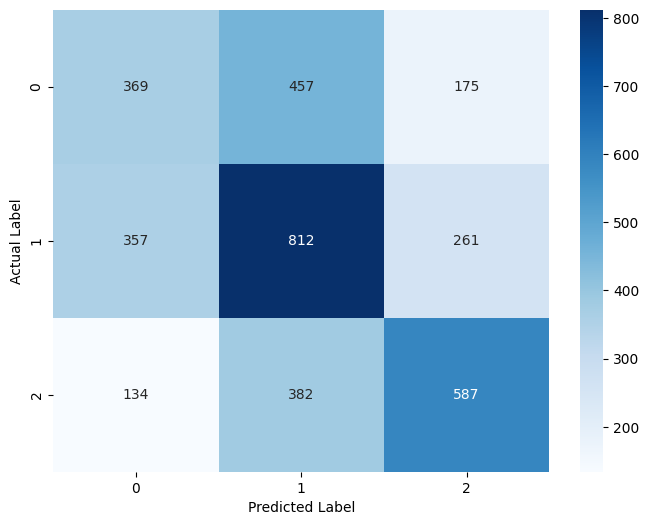

In [ ]:
# Create confusion matrix
conf_matrix = confusion_matrix(y_true_class, y_pred_class)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
# Print classification report

print(classification_report(y_true_class, y_pred_class))

              precision    recall  f1-score   support

           0       0.43      0.37      0.40      1001
           1       0.49      0.57      0.53      1430
           2       0.57      0.53      0.55      1103

    accuracy                           0.50      3534
   macro avg       0.50      0.49      0.49      3534
weighted avg       0.50      0.50      0.50      3534



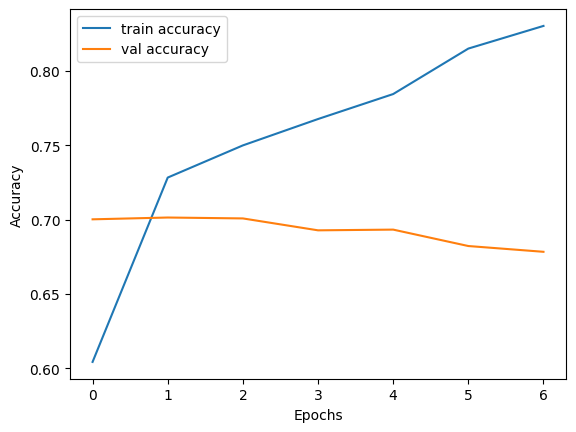

In [ ]:
# Plot accuracy

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Preprocess function from your code
def preprocess_text(text):
    if not isinstance(text, str):
        return ''
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    tokens = [word for word in text.split() if word not in stop_words]
    return ' '.join(tokens)

# Function to predict sentiment in real-time
def predict_sentiment(input_text):
    # Preprocess the input text (same as training data)
    preprocessed_text = preprocess_text(input_text)

    # Tokenize the text
    tokenized_text = tokenizer.texts_to_sequences([preprocessed_text])

    # Pad the tokenized text to ensure it's the right length
    padded_text = pad_sequences(tokenized_text, maxlen=100)

    # Make prediction
    prediction = model.predict(padded_text)

    # Convert the softmax probabilities to class labels
    predicted_class = np.argmax(prediction, axis=1)

    # Map class index to sentiment label
    sentiment_labels = ['negative', 'neutral', 'positive']
    predicted_sentiment = sentiment_labels[predicted_class[0]]

    return predicted_sentiment

# Example usage for real-time prediction
input_sentence = "I love this product, it's amazing!"
predicted_sentiment = predict_sentiment(input_sentence)
print(f"Predicted Sentiment: {predicted_sentiment}")

# You can also set up a loop for continuous input
while True:
    input_text = input("Enter a sentence to analyze sentiment (or type 'exit' to quit): ")
    if input_text.lower() == 'exit':
        break
    sentiment = predict_sentiment(input_text)
    print(f"Predicted Sentiment: {sentiment}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Predicted Sentiment: positive
Enter a sentence to analyze sentiment (or type 'exit' to quit): Riddhi is smart.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted Sentiment: neutral
Enter a sentence to analyze sentiment (or type 'exit' to quit): Lovely is really lovely.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted Sentiment: neutral
Enter a sentence to analyze sentiment (or type 'exit' to quit): I love NLP.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Sentiment: positive
Enter a sentence to analyze sentiment (or type 'exit' to quit): This job is terrible.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted Sentiment: neutral
Enter a sentence to analyze sentiment (or type 'exit' to quit): Pooja is a bad women.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Sentiment: negative
Enter a sentence to analyze sentiment (or type 'exit' to quit): exit
